In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import h5py
import sys
import scipy.io as sio
import skimage.io

sys.path.append("../Visualization/")

from optparse import OptionParser
from Preprocess_Utilities import *
from Visualization import *

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
img_path = '../Data/090085/090085_20170531.h5'
road_dir_path = '../Data/090085/Road_Data/'

In [3]:
# create road mask paths list
road_type = np.array(["motorway", "trunk", "primary", "secondary", "tertiary", "unclassified", "track", # 0-6
                      "residential", "service", "road", "living_street", # 7-10
                      "all_roads"]) # 11 
#                       "motor_trunk_pri_sec_tert_uncl_track", "motor_trunk_pri_sec_tert_uncl"]) # 12-13

road_mask_path = np.char.add(road_dir_path, 
                             np.char.add(np.char.add(road_type, '/'), np.char.add(road_type, '.tif')))

In [4]:
# read in raw image
raw_image = np.array(h5py.File(img_path)['scene'])

# read in road mask
print('road mask loaded in ...')
road_img_list = []
for cur_path in road_mask_path:
    print(cur_path)
    road_img_list.append(skimage.io.imread(cur_path))

road_img_list = np.array(road_img_list)

# assert 0-1 coding
assert (np.logical_or(road_img_list == 1, road_img_list == 0)).all()

road mask loaded in ...
../Data/090085/Road_Data/motorway/motorway.tif
../Data/090085/Road_Data/trunk/trunk.tif
../Data/090085/Road_Data/primary/primary.tif
../Data/090085/Road_Data/secondary/secondary.tif
../Data/090085/Road_Data/tertiary/tertiary.tif
../Data/090085/Road_Data/unclassified/unclassified.tif
../Data/090085/Road_Data/track/track.tif
../Data/090085/Road_Data/residential/residential.tif
../Data/090085/Road_Data/service/service.tif
../Data/090085/Road_Data/road/road.tif
../Data/090085/Road_Data/living_street/living_street.tif
../Data/090085/Road_Data/all_roads/all_roads.tif


In [ ]:
# combine the road mask
print("Used masks ... ")
combined_road_mask = 0
for i in range(11):
    print(road_mask_path[i])
    combined_road_mask += road_img_list[i]
print(combined_road_mask.shape, (combined_road_mask > 1).any())

combined_road_mask[np.where(combined_road_mask > 1)] = 1
assert (np.logical_or(combined_road_mask == 1, combined_road_mask == 0)).all()

In [ ]:
# visualize
# show_pred_prob_with_raw(raw_image, combined_road_mask, road_img_list[-1], pred_weight=1, figsize=(150,150), show_plot=False, save_path='./1')

In [4]:
# save the combined road mask
save_dir_path = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track_res_serv_road_livi/"
skimage.io.imsave(save_dir_path + 'road_mask.tif', combined_road_mask)

NameError: name 'combined_road_mask' is not defined

In [ ]:
# reload combined road mask
combined_road_mask = skimage.io.imread(save_dir_path)

split image in a balanced way

In [ ]:
# pass in the road mask, split on the spcified axis (default to row => up-down split)
def searching_split(raw_image, road_mask, axis=0):

    def get_index_range(i, axis=0):
        if axis: # split from col            
            if i > 5456:
                a = (i-1652)/3.686795
                b = (i-7766)/-0.2988061
            elif i >1752:
                a = (i-1652)/3.686795
                b = (i+23831)/3.787836
            else:
                a = (i-1759)/-0.2625974
                b = (i+23831)/3.787836
            
        else: # split from row
            if i > 6318:
                a = 3.787836*i-23831
                b = -0.2988061*i+7766
            elif i >1534:
                a = -0.2625974*i+1759
                b = -0.2988061*i+7766
            else:
                a = -0.2625974*i+1759
                b = 3.686795*i+1652
        return int(a), int(b)
    
    road_cnt = np.zeros(road_mask.shape[axis])
    print(road_cnt.size)
    for i in range(road_cnt.size):
        start, end = get_index_range(i, axis)
        
        if end-start > 0:
            if axis == 0 and (raw_image[0][i] != -9999).any():
                road_cnt[i] = road_mask[i, start:end+1].sum()
            elif axis == 1 and (raw_image[0][:, i] != -9999).any():
                road_cnt[i] = road_mask[start:end+1,i].sum()

    min_diff = road_cnt.sum() + 1
    idx_list = []
    diff_list = []
    
    for i in range(1,road_cnt.size):
        cur_diff = abs((road_cnt[:i].sum() / i) - (road_cnt[i:].sum() / (road_cnt.size-i)))
        
        if cur_diff < min_diff:
            min_diff = cur_diff
            
            idx_list.append(i)
            diff_list.append(min_diff)
    
    diff_list = np.array(diff_list)
    idx_list = np.array(idx_list)
    
    return idx_list[np.where(diff_list == min_diff)[0]], min_diff

In [ ]:
print(searching_split(raw_image, combined_road_mask, 0))
print()
print(searching_split(raw_image, combined_road_mask, 1))

In [ ]:
print(searching_split(raw_image[:,:1217,:], combined_road_mask[:1217,:], 0))
print()
print(searching_split(raw_image[:,:1217,:], combined_road_mask[:1217,:], 1))

In [ ]:
def img_parallel_line(b):
    return lambda x: (x-1652)/3.686795 + b

In [ ]:
show_image_against_road(raw_image, combined_road_mask, size=-1, figsize=(40,40),
                        show_plot=False, close_plot=False)
# split by row
line_1 = [img_parallel_line(760-170)(x) for x in range(0, combined_road_mask.shape[1])]
line_2 = [img_parallel_line(760)(x) for x in range(0, combined_road_mask.shape[1])]
plt.plot(line_1)
plt.plot(line_2)
plt.show()
plt.close()

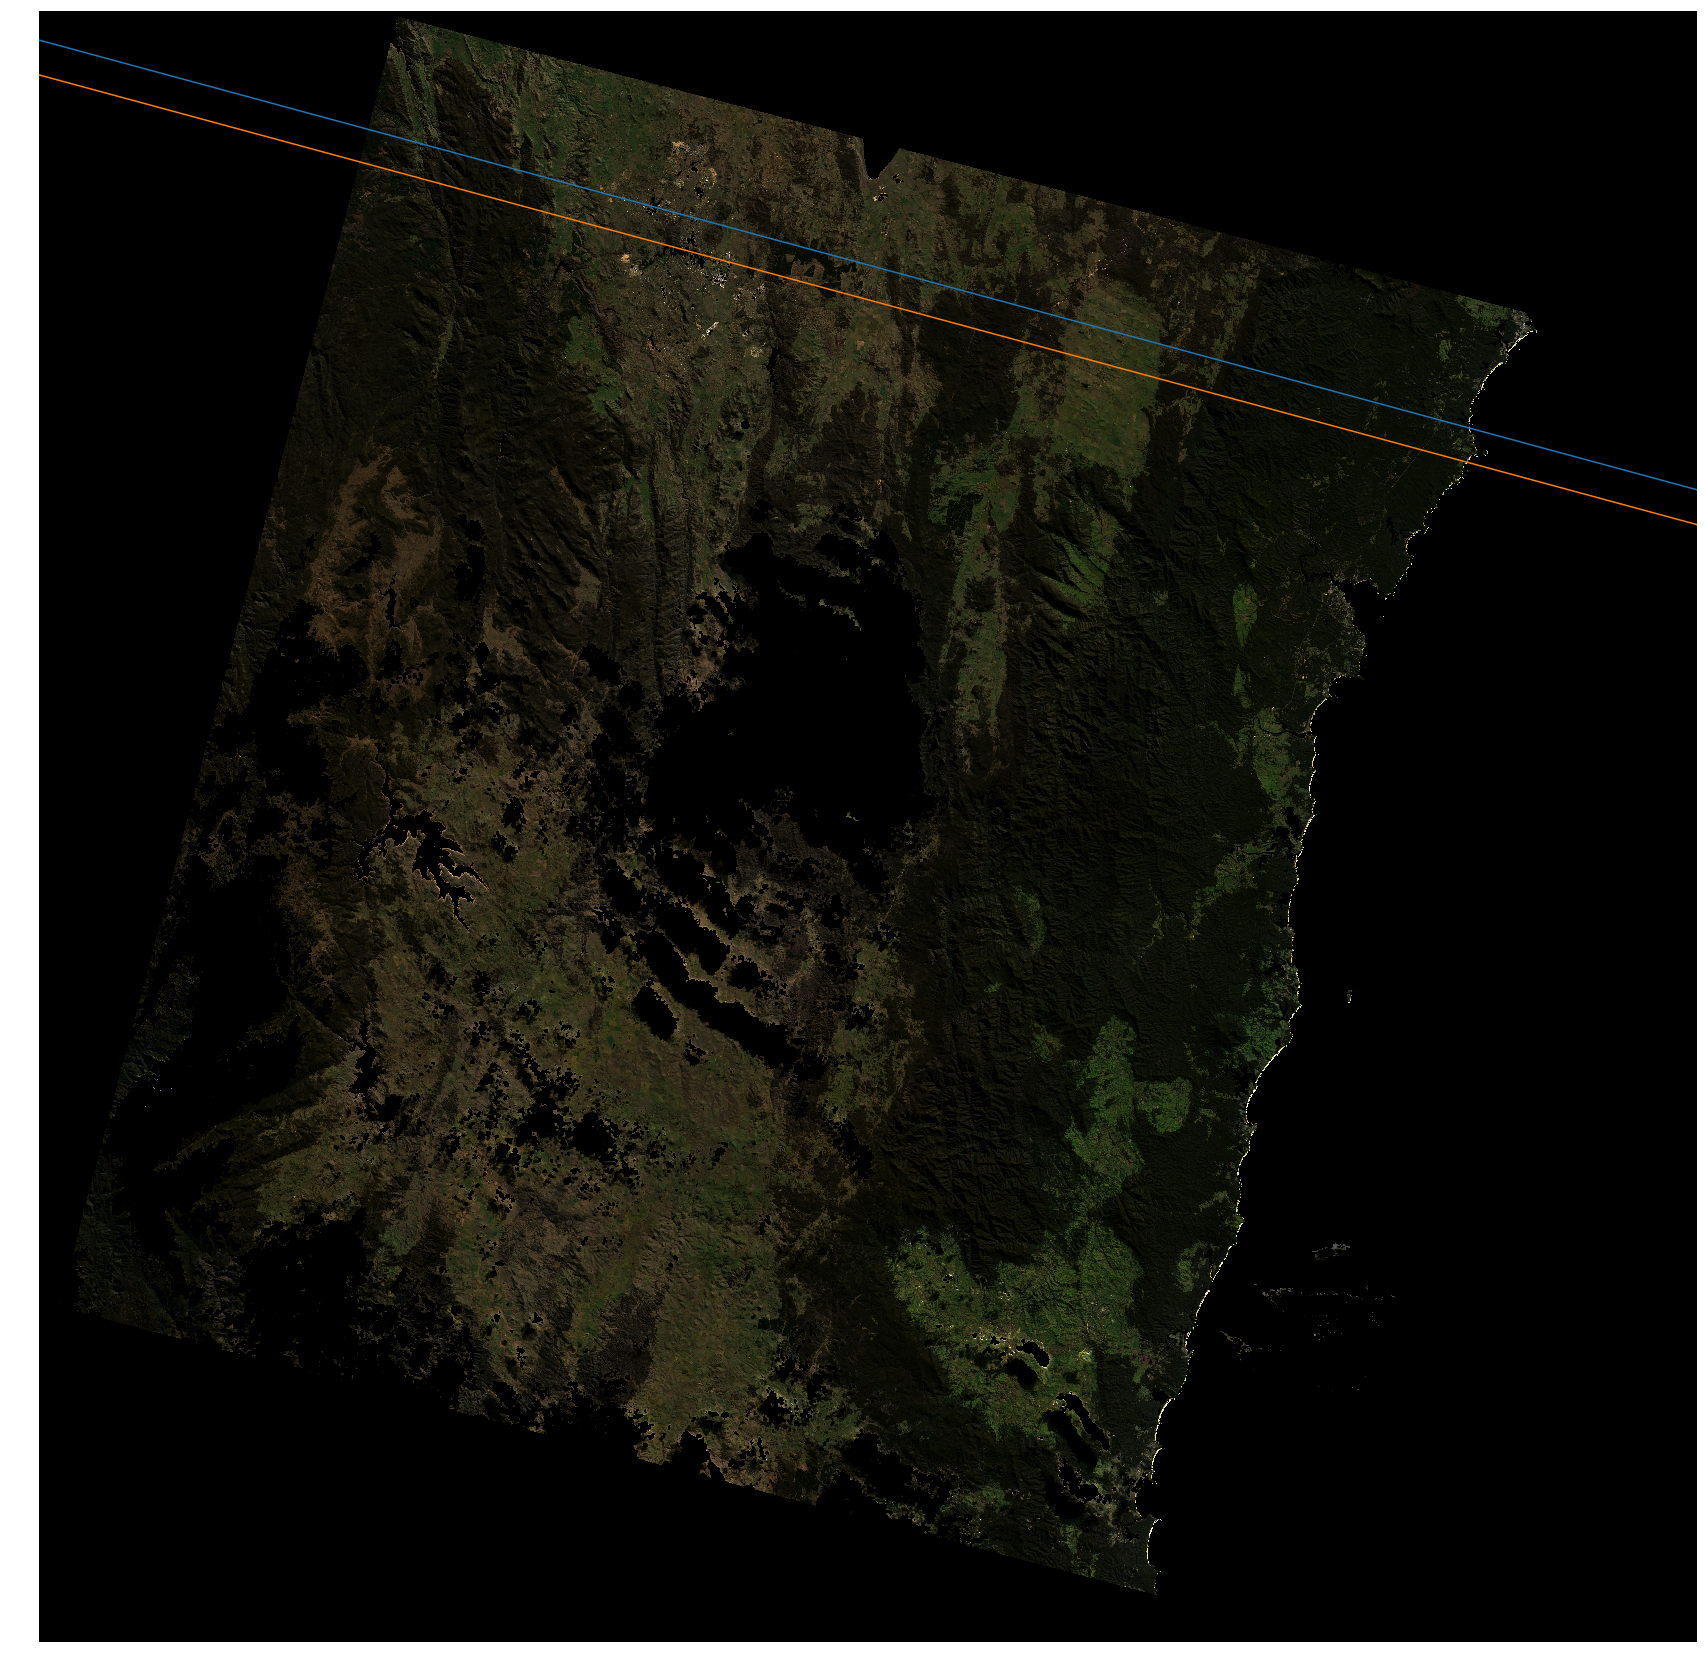

In [10]:
show_raw_image(raw_image, size=-1, figsize=(30,30),
                        show_plot=False, close_plot=False)
plt.plot(line_1)
plt.plot(line_2)

plt.axis('off')
plt.savefig('./Result/data_split.png', bbox_inches='tight', transparent=True)
plt.show()
plt.close()

split set into train cv test

In [ ]:
def copy_into_slice(raw_image, road_mask, height, width, line_1, line_2, base_func, cmp_func):

    road_mask_slice = np.zeros((height, width))
    raw_image_slice = np.zeros((7, height, width))-9999
    print(raw_image_slice.shape, road_mask_slice.shape)

    for i in range(height):
        for j in range(width):
            img_x = base_func(i)

            if cmp_func(img_x, j):
                road_mask_slice[i,j] = road_mask[img_x,j]
                raw_image_slice[:,i,j] = raw_image[:,img_x,j]
                
    return (raw_image_slice, road_mask_slice)

In [ ]:
def copy_road_into_slice(road_mask, height, width, line_1, line_2, base_func, cmp_func):

    road_mask_slice = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            img_x = base_func(i)

            if cmp_func(img_x, j):
                road_mask_slice[i,j] = road_mask[img_x,j]
                
    return road_mask_slice

In [ ]:
# train
raw_image_train, road_mask_train = copy_into_slice(raw_image, combined_road_mask, 
                                                   height= int(combined_road_mask.shape[0]-min(line_2))+1,
                                                   width=combined_road_mask.shape[1], 
                                                   line_1 = line_1, line_2 = line_2,
                                                   base_func = lambda i: i+int(min(line_2)),
                                                   cmp_func = lambda img_x, j: img_x > line_2[j])

show_image_against_road(raw_image_train, road_mask_train, size=-1, figsize=(50,50),
                        show_plot=True, show_raw=False, close_plot=False)

In [ ]:
show_image_against_road(raw_image_train, road_mask_train, size=-1, figsize=(50,50),
                        show_plot=True, show_raw=False, close_plot=False)

In [ ]:
# CV
raw_image_CV, road_mask_CV = copy_into_slice(raw_image, combined_road_mask, 
                                             height= int(combined_road_mask.shape[0]-min(line_2))+1,
                                             width=combined_road_mask.shape[1], 
                                             line_1 = line_1, line_2 = line_2,
                                             base_func = lambda i: i+int(min(line_2)),
                                             cmp_func = lambda x, j: line_1[j] < x and x < line_2[j])

show_image_against_road(raw_image_CV, road_mask_CV, size=-1, figsize=(50,50),
                        show_plot=True, show_raw=False, close_plot=False)

In [ ]:
show_image_against_road(raw_image_cv, road_mask_cv, size=-1, figsize=(50,50),
                        show_plot=True, show_raw=False, close_plot=False)

In [ ]:
# test
raw_image_test, road_mask_test = copy_into_slice(raw_image, combined_road_mask, 
                                                 height= int(max(line_1))+1,
                                                 width=combined_road_mask.shape[1],
                                                 line_1 = line_1, line_2 = line_2,
                                                 base_func = lambda i: i,
                                                 cmp_func = lambda img_x, j: img_x < line_1[j])

show_image_against_road(raw_image_test, road_mask_test, size=-1, figsize=(50,50),
                        show_plot=True, show_raw=False, close_plot=False)

In [ ]:
show_image_against_road(raw_image_test, road_mask_test, size=-1, figsize=(50,50),
                        show_plot=True, show_raw=False, close_plot=False)

Reload image & lines

In [5]:
data_dir = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/"

split_line_name = "img_split_lines.h5"
h5f = h5py.File(data_dir + split_line_name, 'r')
line_1 = list(h5f['line_cv_test'])
line_2 = list(h5f['line_train_cv'])
h5f.close()

img_data_name = "img_split.h5"
h5f = h5py.File(data_dir + img_data_name, 'r')
train_h5f = h5f['train']
raw_image_train = np.array(train_h5f['raw_image'])
road_mask_train = np.array(train_h5f['road_mask'])
    
cv_h5f = h5f['cv']
raw_image_CV = np.array(cv_h5f['raw_image'])
road_mask_CV = np.array(cv_h5f['road_mask'])

test_h5f = h5f['test']
raw_image_test = np.array(test_h5f['raw_image'])
road_mask_test = np.array(test_h5f['road_mask'])
h5f.close()

create top-left coordinate

In [5]:
divide = True
size = 8
name = "posneg_topleft_coord_split_thr1_128_16"
save_dir_path = "../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/"

Train

In [ ]:
# Train
create_set_with_name(raw_image=raw_image_train, combined_road_mask=road_mask_train,
                     divide = divide, step = size, save_dir_path = save_dir_path,
                     name = name+"_train")

CV

In [ ]:
# CV
create_set_with_name(raw_image=raw_image_cv, combined_road_mask=road_mask_cv,
                     divide = divide, step = size, save_dir_path = save_dir_path,
                     name = name+"_cv")

Test

In [ ]:
# Test
create_set_with_name(raw_image=raw_image_test, combined_road_mask=road_mask_test,
                     divide = divide, step = size, save_dir_path = save_dir_path,
                     name = name+"_test")

In [ ]:
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)